In [9]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
pymc.__version__

'5.16.2'

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

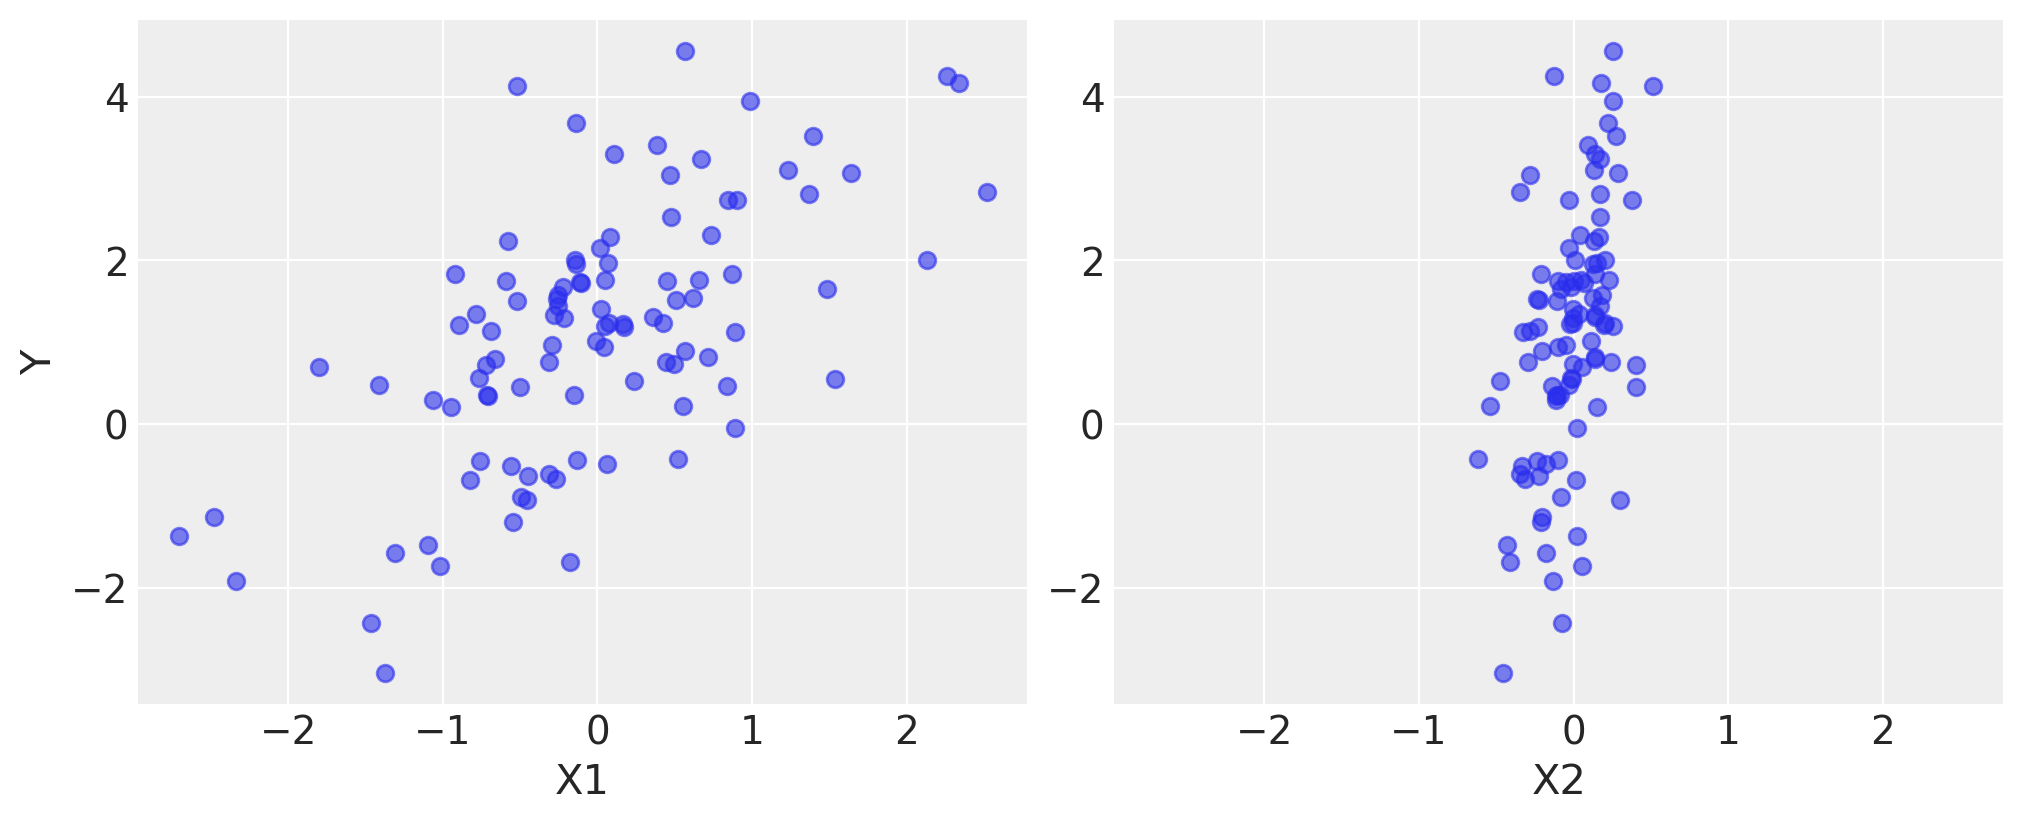

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [42]:
basic_model = pm.Model()  #creates a new Model object which is a container for the model random variables

with basic_model: #all PyMC objects introduced in the indented code block below the with statement are added to the model behind the scenes

    # create stochastic random variables with normally-distributed prior distributions. hese are stochastic because their values are partly determined by their parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).
    # Most commonly-used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial https://www.pymc.io/projects/docs/en/stable/api.html#api
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)  #The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2  #creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values

    # Likelihood (sampling distribution) of observations
    # the parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables.
    Y_obs = pm.Normal("Yobs", mu=mu, sigma=sigma, observed=Y)

In [43]:
basic_model

In [45]:
with basic_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [Yobs, alpha, beta, sigma]


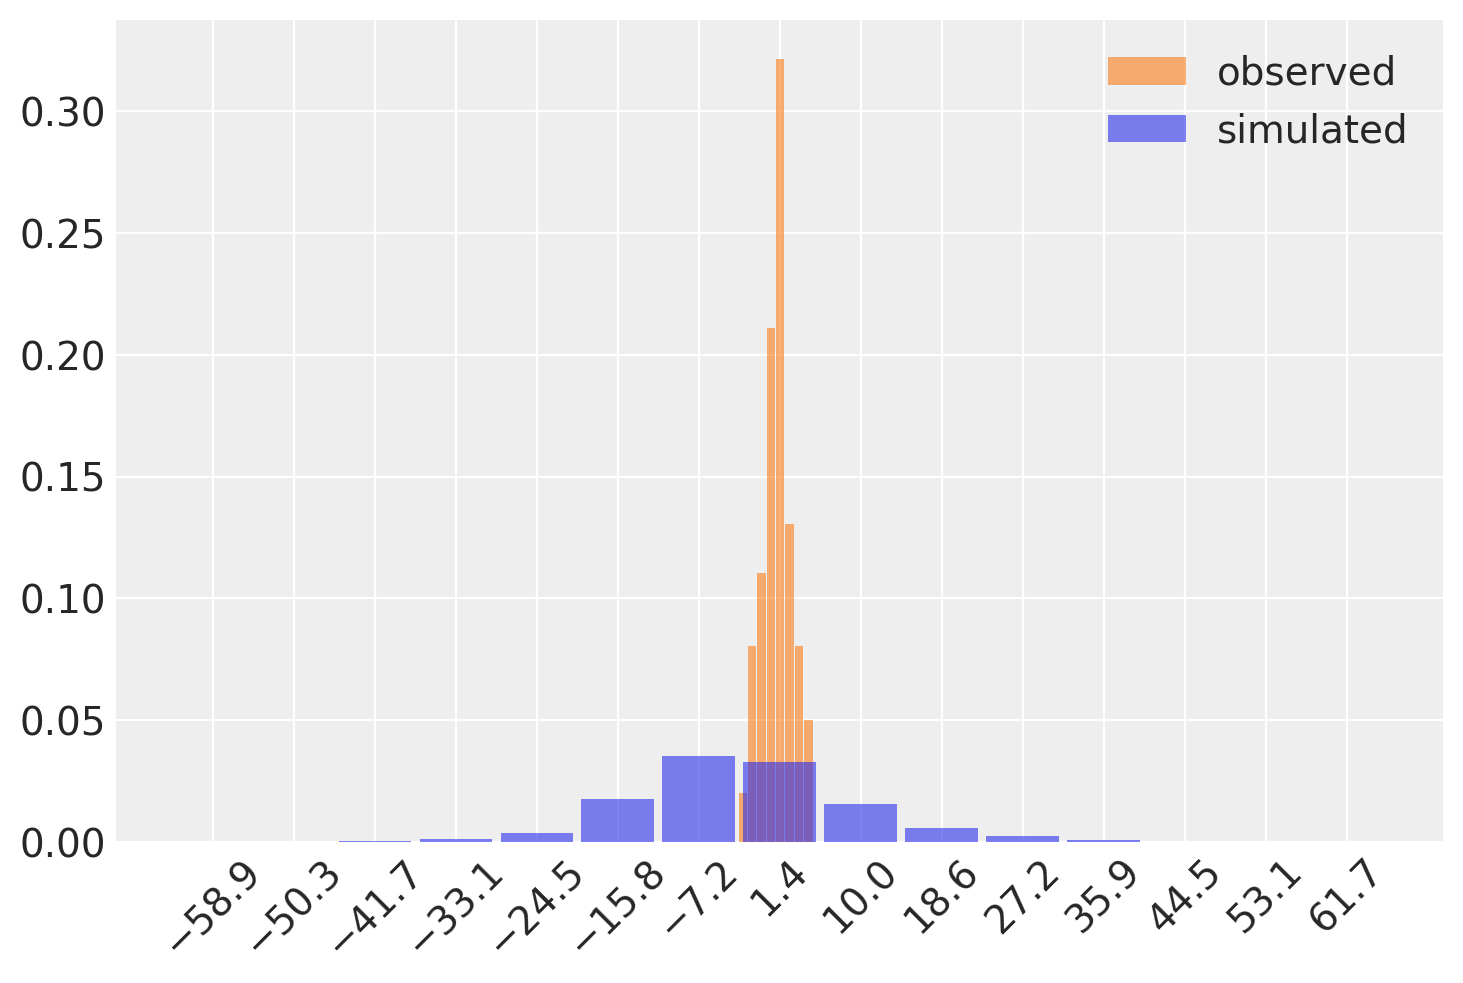

In [46]:
az.plot_dist(
    Y,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["Yobs"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45)

In [14]:
with basic_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

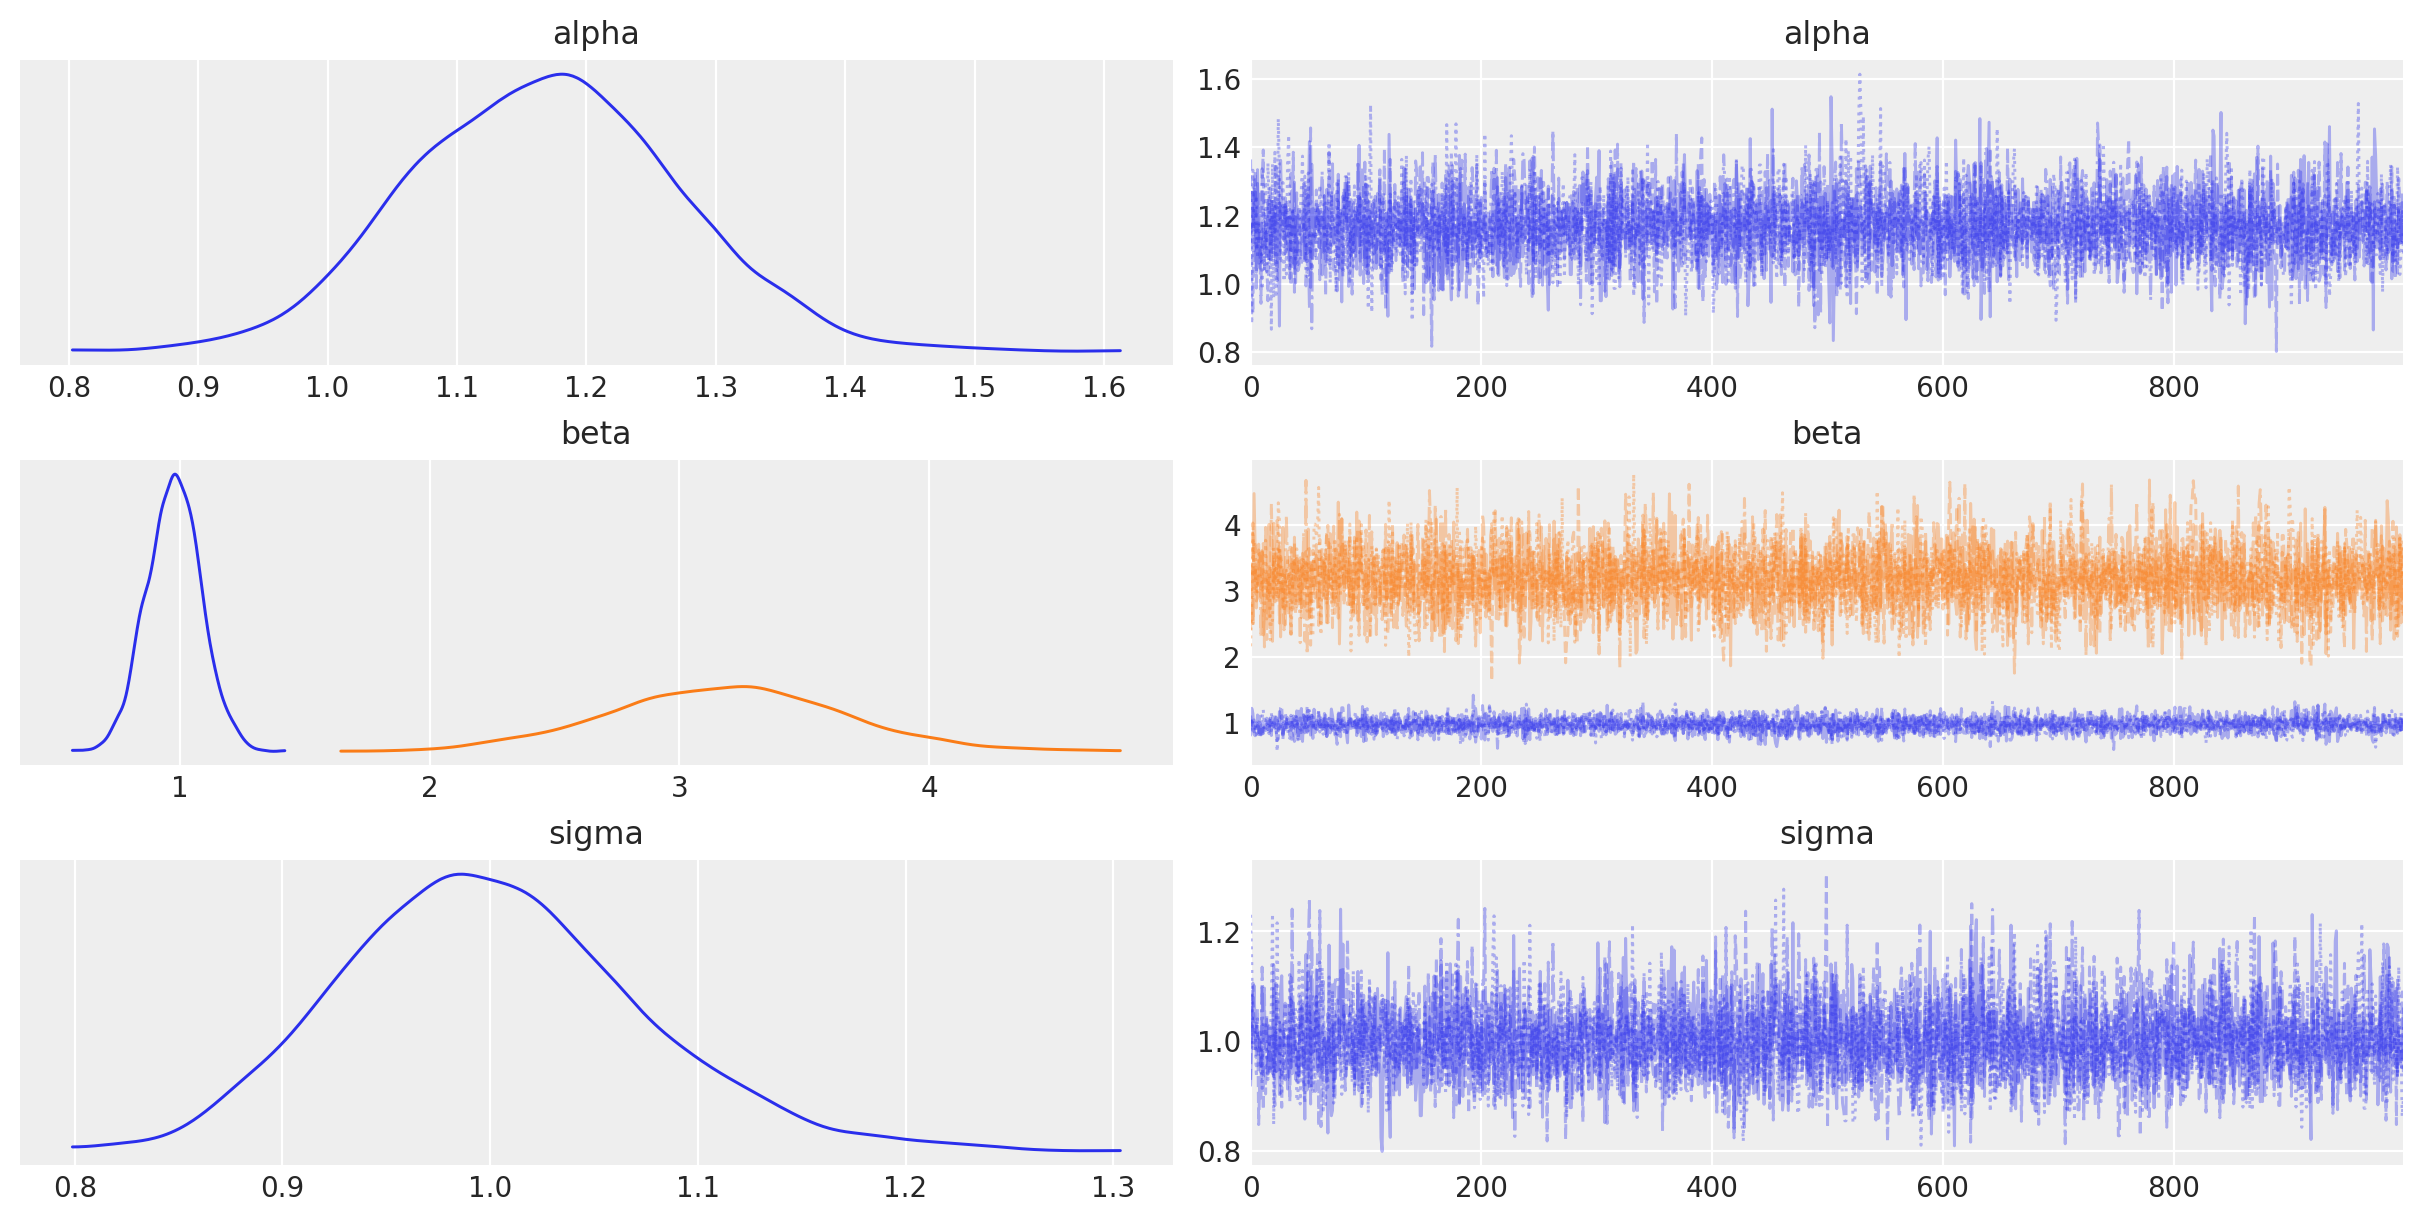

In [20]:
az.plot_trace(idata, combined=True)

In [21]:
az.summary(idata, round_to=1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.2,0.1,1.0,1.4,0.0,0.0,7126.4,3128.8,1.0
beta[0],1.0,0.1,0.8,1.2,0.0,0.0,6001.9,3247.4,1.0
beta[1],3.2,0.5,2.3,4.0,0.0,0.0,4640.6,2845.8,1.0
sigma,1.0,0.1,0.9,1.1,0.0,0.0,6176.7,3019.4,1.0


# Testing with educational dataset

In [22]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


In [47]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [48]:
# Regularization: 
# In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the hierarchical regularized horseshoe (Half-student T)

#One catch is that the parameterization of the prior requires a pre-specified value 
#which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let’s use half the number of predictors as our guess:

D0 = int(D / 2)

In [55]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    #tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    tau = pm.HalfNormal("tau", 2)

    # Local shrinkage prior
    #lam = pm.HalfStudentT("lam", 5, dims="predictors")
    lam = pm.HalfNormal("lam", 5, dims="predictors")
    
    #c2 = pm.InverseGamma("c2", 1, 1)
    c2 = pm.HalfNormal("c2", 1)

    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

In [56]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


In [57]:
test_score_model

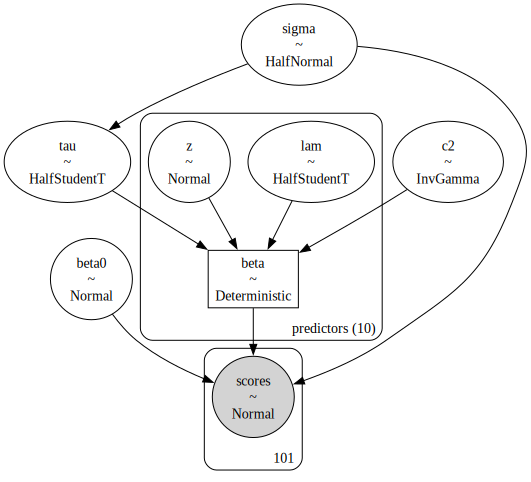

In [30]:
pm.model_to_graphviz(test_score_model)

In [58]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


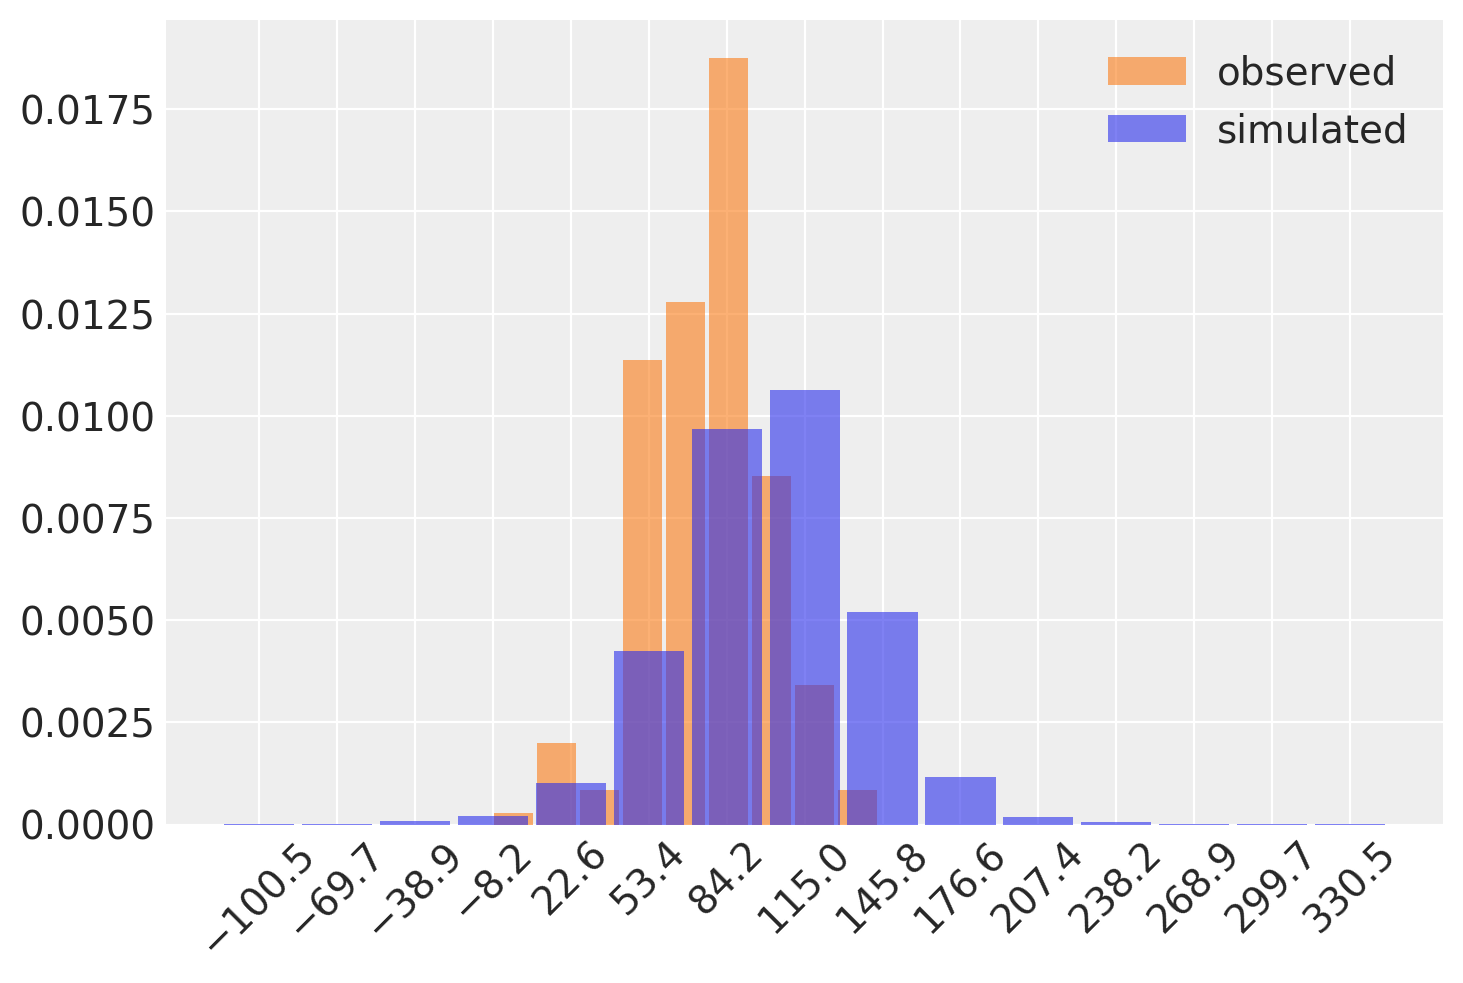

In [59]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

#Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, 
# while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely 
# overlaps the support of the observed distribution of scores; this is a good sign! 

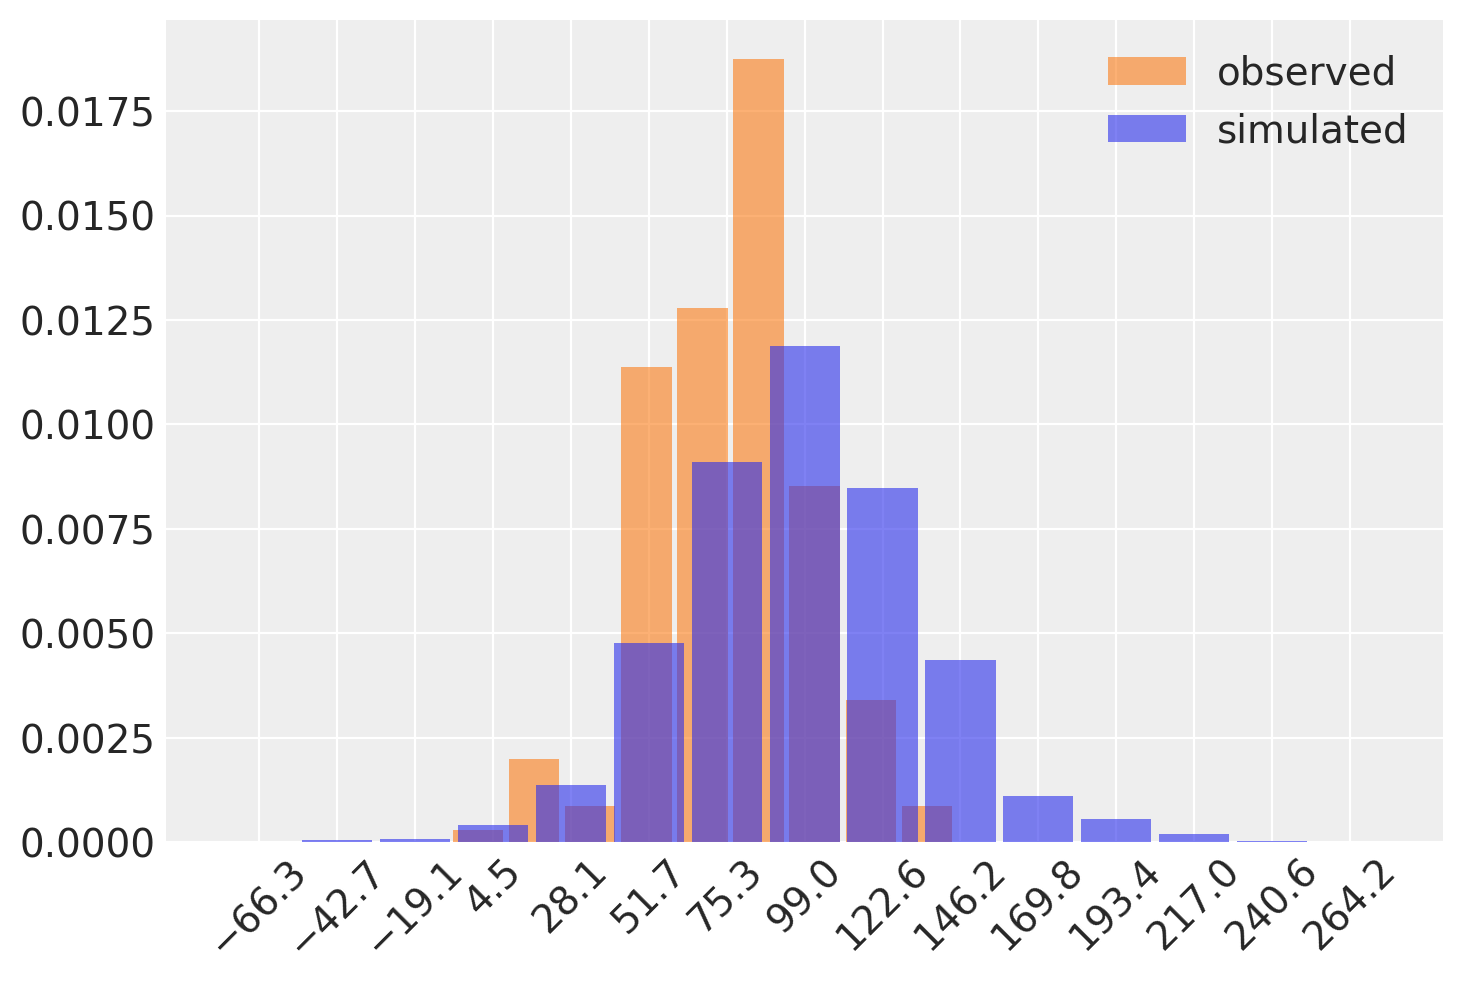

In [54]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

#Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, 
# while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely 
# overlaps the support of the observed distribution of scores; this is a good sign! 

In [61]:
# model fitting
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99) #default target_accept is 0.9. Increasing to 0.99 makes the target acceptance rate larger, so the algorithm is being more conservative with its leapfrog steps, making them smaller

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 72 seconds.


In [69]:
test_score_model

In [66]:
az.summary(data=idata, round_to=1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[male],0.4,1.1,-1.6,2.6,0.0,0.0,6465.6,3061.4,1.0
beta[siblings],-0.6,1.1,-2.9,1.3,0.0,0.0,6289.6,2886.4,1.0
beta[family_inv],-3.7,1.5,-6.6,-0.9,0.0,0.0,2185.2,1312.6,1.0
beta[non_english],-1.6,1.2,-3.9,0.6,0.0,0.0,4254.3,2971.4,1.0
beta[prev_disab],-1.7,1.3,-4.1,0.4,0.0,0.0,3292.6,3078.5,1.0
beta[age_test],0.3,1.1,-1.6,2.5,0.0,0.0,5380.8,2813.3,1.0
beta[non_severe_hl],1.0,1.1,-1.1,3.1,0.0,0.0,4842.5,3278.5,1.0
beta[mother_hs],0.8,1.1,-1.2,2.9,0.0,0.0,5848.1,3181.6,1.0
beta[early_ident],1.3,1.2,-0.8,3.6,0.0,0.0,3125.3,3033.9,1.0
beta[non_white],-1.7,1.3,-4.1,0.5,0.0,0.0,3981.9,3114.3,1.0


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

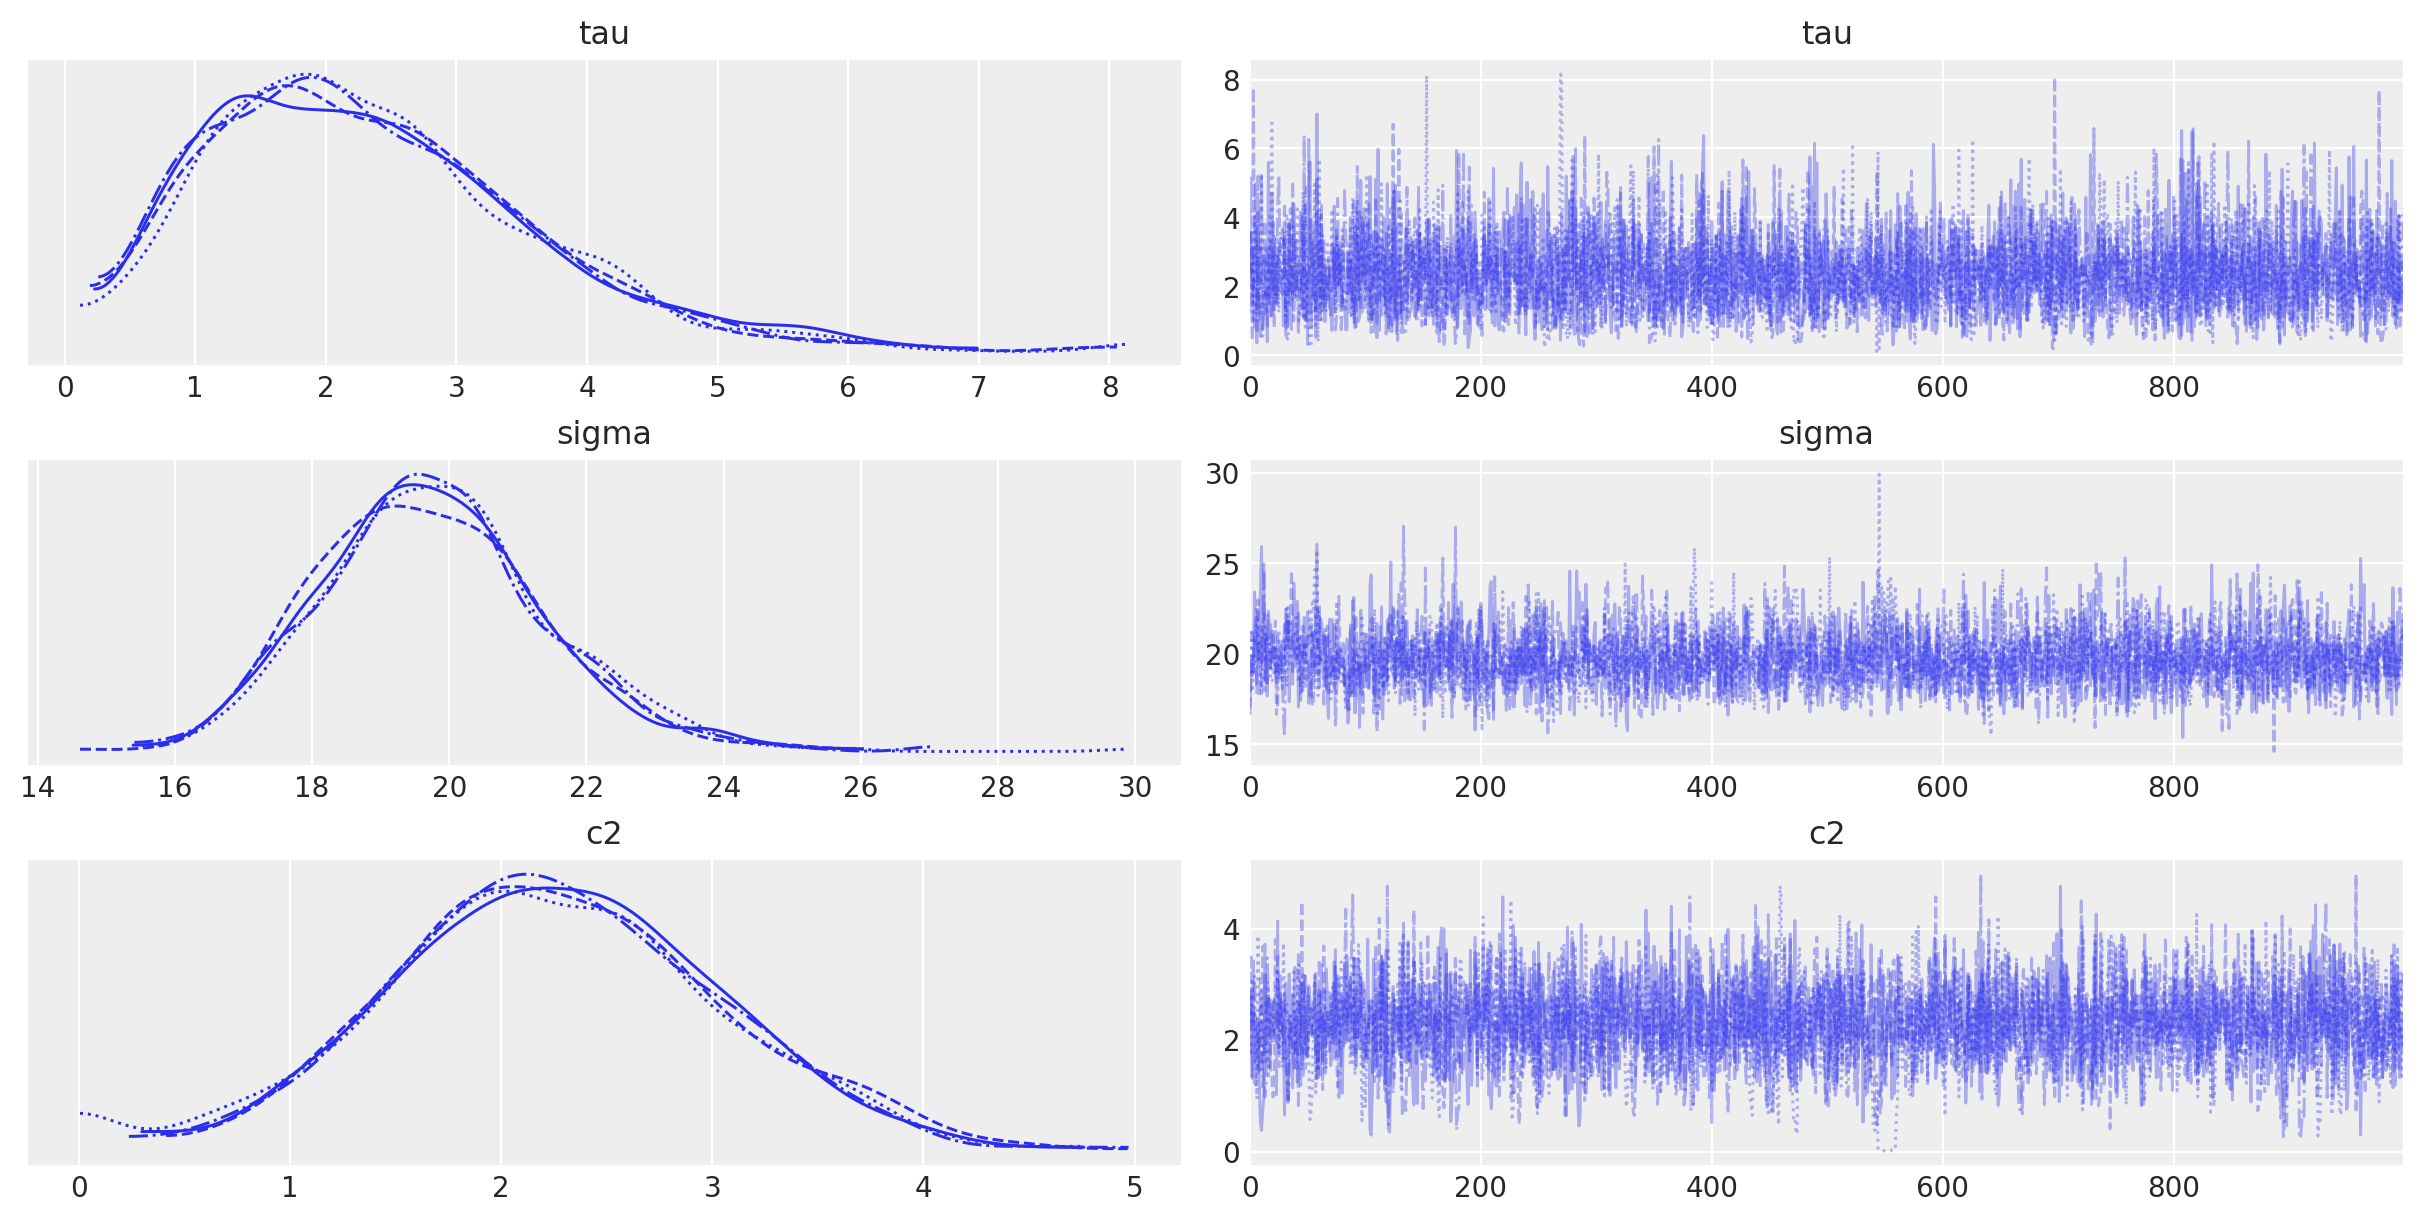

In [62]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"])


#Do these look okay? Well, each of the densities on the left side for each parameter look pretty similar to the others, 
# which means they have converged to the same posterior distribution (be it the correct one or not). 
# The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values.

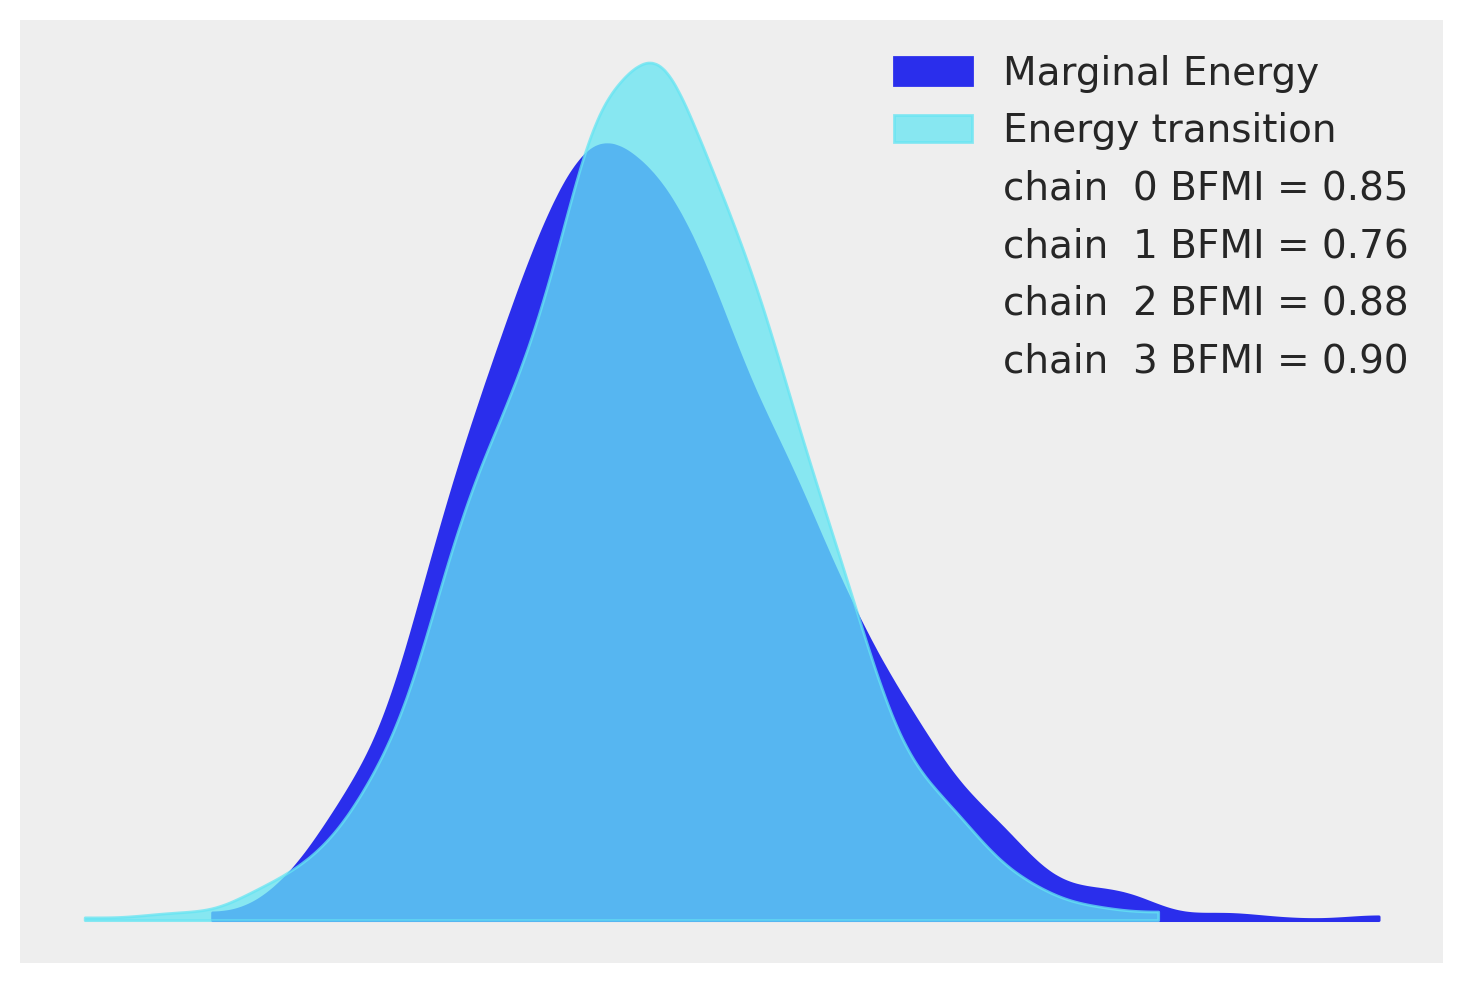

In [63]:
az.plot_energy(idata);

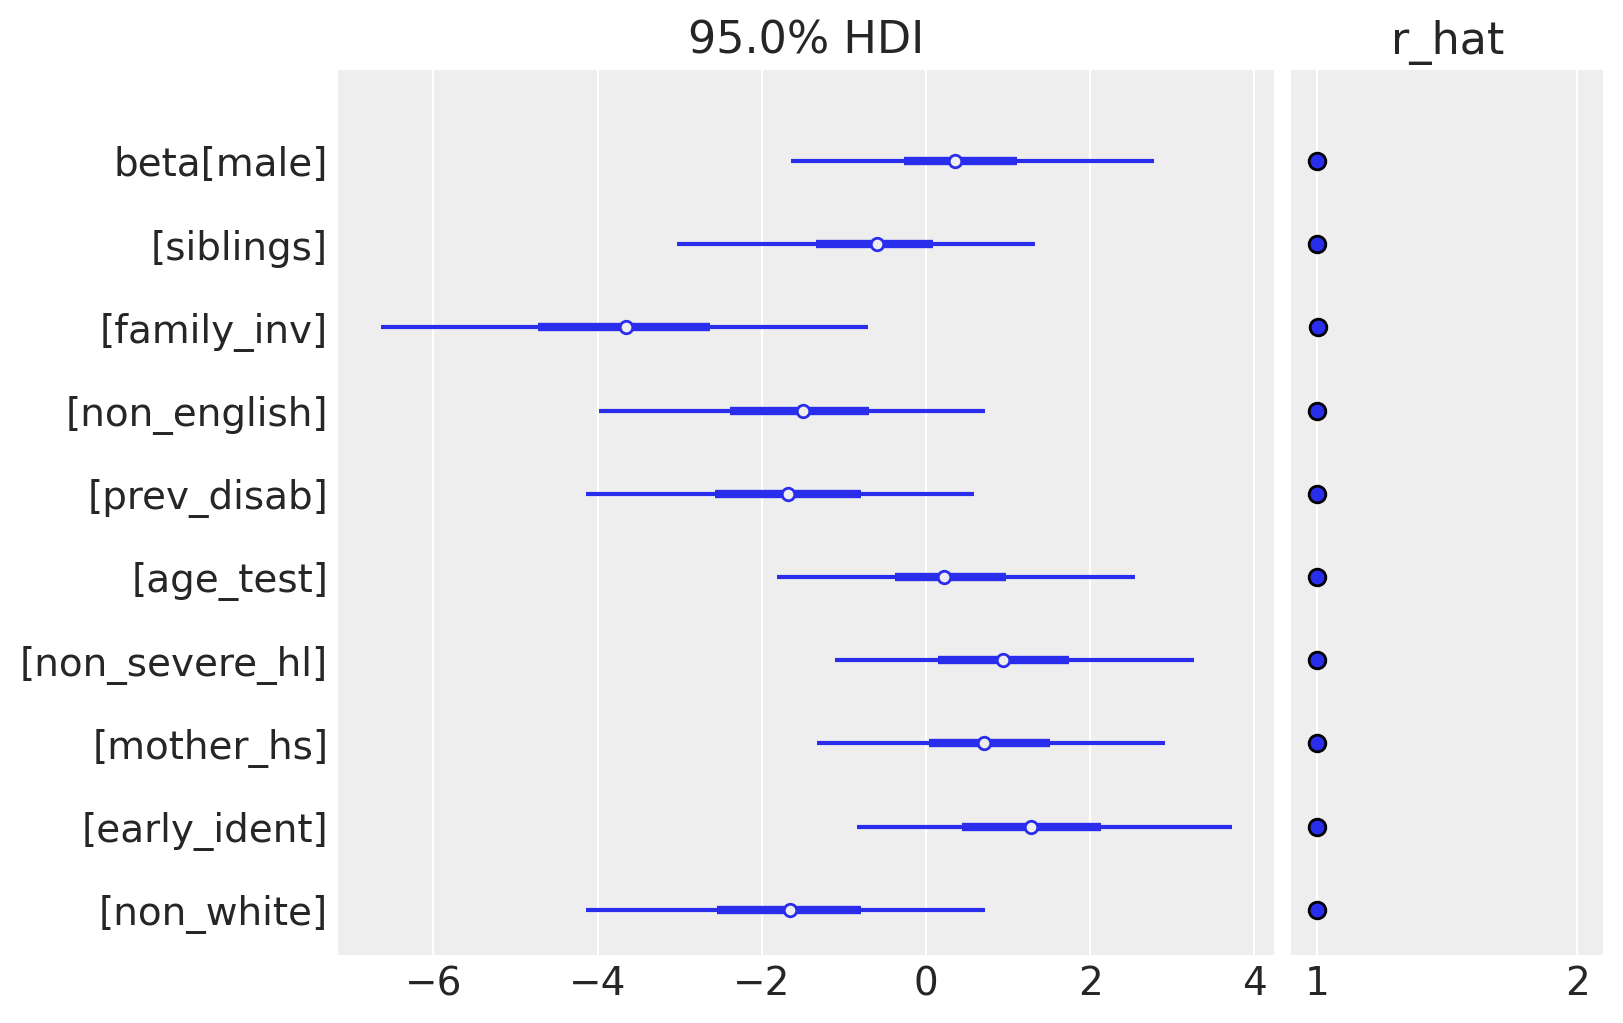

In [64]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [70]:
# PyMC has three core functions that map to the traditional Bayesian workflow:

# sample_prior_predictive (https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_prior_predictive.html)
# sample (https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html)
# sample_posterior_predictive (https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_posterior_predictive.html)
# Prior predictive sampling helps understanding the relationship between the parameter priors and the outcome variable, before any data is observed.

# Sampling is used to infer the posterior distribution of parameters in a model, conditioned on observed data.

# Finally, posterior predictive sampling can be used to predict new outcomes, conditioned on the posterior parameters.